In [63]:
 import matplotlib.pylab as plt
 import numpy as np
 from numpy.linalg import inv
 import pandas as pd
 from pandas_datareader import data as web
 from scipy.optimize import minimize

In [64]:
 # 파이썬은 함수 안에 함수를 정의할 수 있다.
 # 최적 비중 계산을 위해 다음과 같이 목적함수를 정의한다.
def solveWeights( R, C, rf ):
  def obj( W, R, C, rf ):
     mean = sum( R * W )
     var = np.dot( np.dot( W, C ), W )

# 샤프비율을 효용함수로 한다. 
     util = ( mean - rf ) / np.sqrt( var )    

# 효용함수 극대화는 효용함수 역함수를 최소화하는 것이다
     return 1 / util

# 투자자산 개수
  n = len( R )

# 동일 비중으로 최적화 시작
  W = np.ones([n]) / n

# 비중 범위는 0~100% 사이 (공매도나 차입조건이 없음)
  bnds = [(0., 1.) for i in range( n ) ]

# 계약 조건은 비중합 = 100%
  cons = ( { 'type': 'eq', 'fun': lambda W: sum( W ) -1. } )

# 최적화
  res = minimize( obj, W, ( R, C, rf), method='SLSQP', constraints=cons, bounds=bnds)

# 최적화의 성공 여부를 확인한다.
  if not res.success:

  # 최적화에 실패한 경우
    raise BaseException( res.message )

# 최적화 결과를 돌려준다.
  return res.x

# 무위험수익률, 수익률, 공분산으로 효율적 투자선 계산
def solveFrontier( R, C, rf):

  # 파이썬은 함수 안에[ 함수를 정의할 수 있다.
  # 최적 비중 계산을 위해 다음과 같이 목적함수를 정의한다.
  def obj( W, R, C, r ):

    # 주어진 수익률에서 분산을 최소화하는 비중 계산
    mean = sum( R * W )
    var = np.dot( np.dot( W, C ), W )

    # 최적화 제약조건 페널티     
    penalty = 100 * abs( mean - r )
    return var + penalty

  # 효율적 투자선을 구성하는 평균-분산을 돌려줄
  # 리스트를 미리 준비한다.
  frontier_mean, frontier_var = [], []

  # 투자자산 개수
  n = len( R )

  # 수익률 최저에서 최대 사이를 반복한다.
  for r in np.linspace( min( R ), max( R ), num=20 ):

    # 최적화 함수에 전달할 초깃값을 동일 비중으로 시작한다.
    W = np.ones([n]) / n 

    # 최적화 함수에 전달할 범위조건과 제약조건을 미리 준비한다.
    # 범위조건: 각 구성 자산의 투자 비중은 0~100% 사이다.
    # 제약조건: 전체 투자 비중은 100%이다.
    bnds = [ ( 0, 1 ) for i in range( n ) ]
    cons = ( { 'type': 'eq', 'fun': lambda W: sum(W) - 1. } )

    # 최적화 함수 minimize()는 최적화할 obj 함수와 
    # 최적화를 시작할 초깃값을 인수로 받는다.    
    res = minimize( obj, W, ( R, C, r ), method='SLSQP', constraints = cons, bounds = bnds)
    if not res.success:

      # 최적화에 실패한 경우
      raise BaseException( res.message )

      # 효율적 투자선 평균과 분산 리스트에
      # 최적 포트폴리오 수익률과 분산 추가
      frontier_mean.append( r )      
      frontier_var.append( np.dot( np.dot( res.x, C ), res.x ) )
    return np.array( frontier_mean ), np.array( frontier_var )

# 효율적 포트폴리오 최적화: 위 두 개의 최적화 함수를 호출한다.   
def optimize_frontier( R, C, rf ):

  #접점포트폴리오 계산
  W = solveWeights( R, C, rf )

  # 투자 비중으로 계산한 평균과 분산
  tan_mean = sum( R * W )
  tan_var = np.dot( np.dot( W, C ), W)

  # 효율적 포트폴리오 계산
  eff_mean, eff_var = solveFrontier( R, C, rf )

  # 비중, 접점포트폴리오의 평균/분산, 효율적 포트폴리오의 평균/분산을 
  # 딕셔너리 데이터형으로 돌려준다.
  return { 'weights':W, 'tan_mean':tan_mean, 'tan_var':tan_var, 'eff_mean':eff_mean, 'eff_var':eff_var }

# 자산에 대한 투자자의 전망과 전망의 기대수익률을 행렬로 만든다.
def CreateMatrixPQ( names, views ):
  r, c = len( views ), len( names )

  # 투자 전망과 기대수익률 행렬      
  # views[ i ][ 3 ]은 기대수익률을 가리킴
  Q = [ views[ i ][ 3 ] for i in range( r ) ]

  # 전망 행렬 P를 만들기 위해 
  # 구성 자산 딕셔너리 작성
  nameToIndex = dict()
  for i, n in enumerate( names ):
    nameToIndex[ n ] = i

  # 투자 전망
  P = np.zeros( [ r, c ] )
  for i, v in enumerate( views ):
    name1, name2 = views[ i ][ 0 ], views[ i ][ 2 ]
    P[ i, nameToIndex[ name1 ] ] = +1 if views[ i ][ 1 ] == '>' else -1
    P[ i, nameToIndex[ name2 ] ] = -1 if views[ i ][ 1 ] == '>' else +1
  return np.array( Q ), P

In [65]:
### 데이터 읽기 ###      
# 여덟 개 주식을 야후 파이낸스에서 가져오고 시가총액은 cap에 저장했다.
tickers = [ 'PFE', 'INTC', 'NFLX', 'JPM', 'XOM', 'GOOG', 'JNJ', 'AAPL', 'AMZN' ]

cap = {'PFE':201102000000,'INTC':257259000000,'NFLX':184922000000,
       'JPM':272178000000,'XOM':178228000000,'GOOG':866683000000,
       'JNJ':403335000000,'AAPL':1208000000000,'AMZN':1178000000000
      }

# 빈 리스트를 준비한다
prices, caps = [], []

# 여덟 개 종목을 반복하면서 수정주가와 시가총액을 저장한다.
for s in tickers:
  pxclose = web.DataReader( s, data_source='yahoo', start='01-01-2018', end='31-12-2019' )[ 'Adj Close' ]
  prices.append( list( pxclose ) )
  caps.append( cap[ s ] )

### 최적화에 사용할 필요한 값을 미리 계산 ###
# 포트폴리오 내 종목의 개수
n = len( tickers )

# 시가총액의 비율 계산
W = np.array( caps ) / sum( caps )

# prices를 numpy matrix로 변환
prices = np.matrix( prices )

# 수익률 행렬을 만들어 계산한다.
rows, cols = prices.shape
returns = np.empty( [rows, cols -1 ] )
for r in range ( rows ):
  for c in range( cols - 1 ):
    p0, p1 = prices[ r, c ], prices[ r, c + 1 ]
    returns[ r, c ] = ( p1 / p0 ) - 1

# 수익률 계산
expreturns = np.array( [] )
for r in range( rows ):
  expreturns = np.append( expreturns, np.mean( returns[ r ] ) )

# 공분산 계산
covars = np.cov( returns )
R = ( 1 + expreturns ) ** 250 - 1 # 연율화
C = covars * 250 # 연율화

# 무위험이자율
rf = .015

In [69]:
# diaplay 함수는 데이터를 출력하며
# 이는 코랩에서만 사용할 수 있다.
# 수익률과 시가총액 비중을 출력한다.
display( pd.DataFrame( { 'Return': R, 'Weight (based on market cap)': W}, index=tickers).T )

# 공분산을 출력한다.
display( pd.DataFrame( C, columns=tickers, index=tickers ) )

### 과거 데이터를 이용한 최적화 ###
# 평균-분산 최적화
opt1 = optimize_frontier( R, C, rf )

### 블랙-리터만 역최적화###
# 포트폴리오 수익률 평균 및 분산
mean = sum( R * W )
var = np.dot( np.dot( W, C ), W )

# 위험회피계수
lmbda = ( mean - rf ) / var

# 균형초과수익률
pi = np.dot( np.dot( lmbda, C ), W )

,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Return,0.094701,0.213133,0.376207,0.190982,-0.034127,0.158643,0.071697,0.374548,0.303104
Weight (based on market cap),0.042340,0.054163,0.038933,0.057304,0.037524,0.182471,0.084918,0.254331,0.248015


,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
PFE,0.037363,0.021650,0.026020,0.015811,0.015772,0.018532,0.018269,0.019717,0.021559
INTC,0.021650,0.093410,0.054385,0.029809,0.027001,0.039814,0.017512,0.045336,0.042400
NFLX,0.026020,0.054385,0.165254,0.031729,0.027571,0.060201,0.020956,0.053070,0.081353
JPM,0.015811,0.029809,0.031729,0.041792,0.022180,0.028015,0.014417,0.027610,0.029125
XOM,0.015772,0.027001,0.027571,0.022180,0.040334,0.024196,0.014377,0.023426,0.022529
GOOG,0.018532,0.039814,0.060201,0.028015,0.024196,0.068071,0.016314,0.044830,0.054362
JNJ,0.018269,0.017512,0.020956,0.014417,0.014377,0.016314,0.037225,0.015872,0.016410
AAPL,0.019717,0.045336,0.053070,0.027610,0.023426,0.044830,0.015872,0.075180,0.051311
AMZN,0.021559,0.042400,0.081353,0.029125,0.022529,0.054362,0.016410,0.051311,0.090502


In [74]:
### 균형기대수익률로 최적화 ###
# 균형기대수익률로 최적화(투자자의 전망 없이)
opt2 = optimize_frontier( pi+rf, C, rf )

###투자자 전망과 기대수익률, 전망의 불확실성 계산"""
views = [ ( 'XOM', '>', 'JPM', 0.02 ), ('NFLX', '<', 'JNJ', 0.02 ) ]
Q, P = CreateMatrixPQ( tickers, views )

# 위험조정상수
tau = .025

# 투자자 전망의 불확실성 계산
# tau * P * C * transpose( P )
omega = np.dot( np.dot( np.dot( tau, P ), C ), np.transpose( P ) ) 

### 블랙-리터만 모델 최적화 ###
# 투자자 전망을 더한 균형초과수익률 계산
bl1 = inv( np.dot( tau, C ) )
bl2 = np.dot( np.dot( np.transpose( P ), inv( omega ) ), P)
bl3 = np.dot( inv( np.dot( tau, C ) ), pi )
bl4 = np.dot( np.dot( np.transpose( P ), inv( omega ) ), Q )
pi_adj = np.dot( inv( bl1 + bl2 ), ( bl3 + bl4 ) )

opt3 = optimize_frontier( pi_adj + rf, C, rf )

In [75]:
# 세 개의 최적화 결과를 테이블 형식으로 정리해 출력한다.
from IPython.core.display import display, HTML
pd.options.display.float_format = '{:.2%}'.format

# 첫 번째 최적화 결과
display( HTML( '<h2>Historical returns</h2>') )
display( pd.DataFrame( { 'Weight': opt1[ 'weights' ]}, index=tickers).T)

,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Weight,0.00%,0.00%,12.95%,19.30%,0.00%,0.00%,0.00%,67.75%,0.00%


In [76]:
# 두 번째 최적화 결과
display( HTML( '<h2>Implied returns</h2>' ) )
display( pd.DataFrame( { 'Weight': opt2[ 'weights' ]}, index=tickers).T )

,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Weight,4.28%,5.40%,3.90%,5.74%,3.73%,18.26%,8.46%,25.43%,24.80%


In [77]:
# 세 번째 최적화 결과
display( HTML( '<h2>Implied returns with adjusted views</h2>' ) )
display( pd.DataFrame( { 'Weight': opt3[ 'weights' ]}, index=tickers).T )

,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Weight,3.24%,3.61%,0.00%,0.00%,11.71%,15.74%,21.83%,25.67%,18.20%


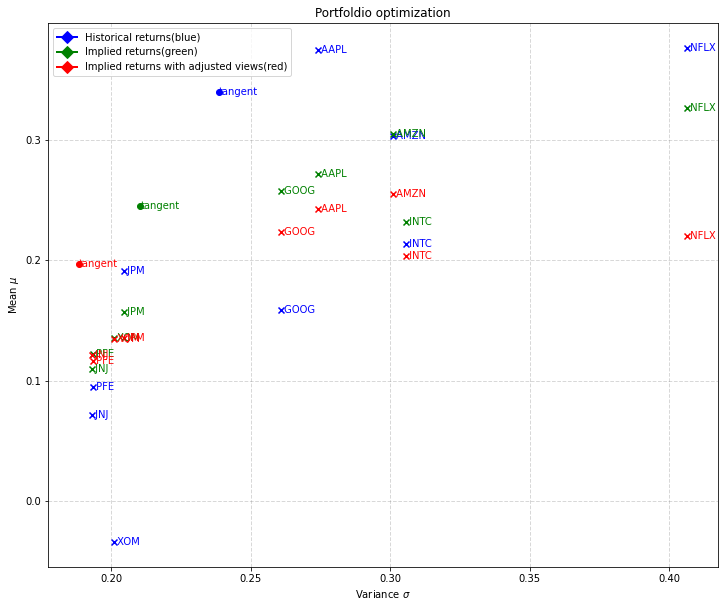

In [98]:
# plotAssets와 plotFrontier는 차트를 그리기 위한 함수다
def plotAssets(tickers, R, C, color='black' ):

# 포트폴리오 구성 자산 출력
  plt.scatter( [ C[i, i] ** .5 for i in range( n ) ], R, marker='x', color=color )
  for i in range( n ):
    plt.text(C[i, i] ** .5, R[i], ' %s' % tickers[i], verticalalignment = 'center', color=color )

def plotFrontier( result, label=None, color='black' ):
# 최적화된 효율적 투자선 출력
  plt.text( result[ 'tan_var' ] ** .5, result[ 'tan_mean'], 'tangent', verticalalignment='center', color=color )
  plt.scatter( result[ 'tan_var' ] ** .5, result[ 'tan_mean' ], marker='o', color=color )
  plt.plot( result[ 'eff_var' ] ** .5, result[ 'eff_mean' ], label=label, color=color, linewidth=2, marker='D', markersize=9 )

# 첫 번째 최적화 경과를 차트로 출력
plotAssets( tickers, R, C, color='blue')
plotFrontier( opt1, label='Historical returns', color='blue' )

# 두 번째 최적화 결과를 차트로 출력
plotAssets( tickers, pi+rf, C, color='green' )
plotFrontier( opt2, label='Implied returns', color='green' )

# 세 번째 최적화 결과를 차트로 출력
plotAssets( tickers, pi_adj+rf, C, color='red' )
plotFrontier( opt3, label='Implied returns (adjusted views)', color='red' )

# 차트에 공통된 속성을 지정한다(차트 크기, 제목, 범례, 축 이름 등)
plt.rcParams[ "figure.figsize" ] = ( 12, 10 )
plt.grid( alpha=0.3, color='gray', linestyle='--', linewidth=1 )
plt.title( 'Portfoldio optimization' ) 
plt.legend( [ 'Historical returns(blue)', 'Implied returns(green)', 'Implied returns with adjusted views(red)' ])
plt.xlabel( 'Variance $\sigma$')
plt.ylabel( 'Mean $\mu$' )
plt.show()